# Library Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.losses import BinaryCrossentropy
from keras.regularizers import l2, l1, l1_l2
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
class Colours:
    HEADER = '\033[95m'     # Parameters
    BLUE = '\033[94m'       # Class Distribution
    GREEN = '\033[92m'      # Accuracies
    RED = '\033[91m'        # Loss
    ENDC = '\033[0m'        # End Colours
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Dataset Loading, Cleaning, & Splitting

In [3]:
# Load the dataset
data = pd.read_csv('diabetes.csv')

In [4]:
# Clean the data

# Glucose: Replace '0' values with NaN
data['Glucose'] = data['Glucose'].apply(lambda x: np.nan if x == 0 else x)

# BloodPressure: Replace values below 40 mm Hg with NaN
data['BloodPressure'] = data['BloodPressure'].apply(lambda x: np.nan if x < 40 else x)

# SkinThickness: Replace values below 10 mm with NaN
data['SkinThickness'] = data['SkinThickness'].apply(lambda x: np.nan if x < 10 else x)

# Insulin: Replace values above 400 µU/mL with NaN
data['Insulin'] = data['Insulin'].apply(lambda x: np.nan if x > 400 else x)

# BMI: Replace '0' values with NaN
data['BMI'] = data['BMI'].apply(lambda x: np.nan if x == 0 else x)

In [5]:
# Split the data into training, testing, and validation datasets

# Split the data into features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the dataset into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [6]:
print(f"Class distribution: {Colours.BLUE}{np.bincount(y)}{Colours.ENDC}")

Class distribution: [500 268]


# Data Preprocessing

In [7]:
# Preprocess the data by performing KNN Imputation and scaling the dataset with RobustScaler

imputer = KNNImputer(n_neighbors=5)
scaler = RobustScaler()

# Impute and scale training dataset
X_train_imputed = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Impute and scale validation dataset
X_val_imputed = imputer.transform(X_val)
X_val_scaled = scaler.transform(X_val_imputed)

# Impute and scale trainval dataset
X_trainval_imputed = imputer.fit_transform(X_trainval)
X_trainval_scaled = scaler.fit_transform(X_trainval_imputed)

# Impute and scale testing dataset
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Dummy Classifier Pipeline

In [8]:
# Defining a dummy classifier pipeline
dummyPipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler()),
    ('classifier', DummyClassifier(strategy='stratified'))
])

# Standard Single Layer Perceptron

In [9]:
# Defining a standard single-layer perceptron
def ssl_perceptron(learning_rate=0.01):
    model = Sequential()

    model.add(Dense(1, input_dim=X_train.shape[1], activation='linear'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    
    return model

# Optimized Single Layer Perceptron

In [10]:
# Defining the optimized single-layer perceptron
def osl_perceptron(learning_rate=0.01, activation='binary', regularization=None, lambda_=0.01, optimizer='adam'):
    model = Sequential()

    if regularization == 'l1':
        kernel_regularizer = l1(lambda_)
    elif regularization == 'l2':
        kernel_regularizer = l2(lambda_)
    elif regularization == 'elasticnet':
        kernel_regularizer = l1_l2(l1=lambda_, l2=lambda_)
    else:
        kernel_regularizer = None
    
    if activation == 'binary':
        model.add(Dense(1, input_dim=X_train.shape[1], activation='linear', kernel_regularizer=kernel_regularizer))
    else:
        model.add(Dense(1, input_dim=X_train.shape[1], activation=activation, kernel_regularizer=kernel_regularizer))

    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance,
                  loss=BinaryCrossentropy(from_logits=True) if activation == 'binary' else BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    return model

# Priliminary Model Training, Hyperparameter Tuning, & Validation Evaluation

In [11]:
# Conduct hyperparameter tuning on the Optimized Single Layer Perceptron (OSLP) model

# Hyperparameter space
learning_rates = [0.001, 0.01]                      # Learning rate values to test
epochs_list = [500, 750]                            # Number of iterations (epochs) to test
activations = ['sigmoid', 'tanh', 'relu']           # Activation functions to test
regularizations = [None, 'l1', 'l2', 'elasticnet']  # Regularization types to test
lambda_values = [0.001, 0.01]                       # Regularization strengths to test
optimizers = ['adam', 'sgd']                        # Optimization methods to test

# Tuning metrics
best_accuracy = 0
best_params = {}

# Hyperparameter tuning loop
for learning_rate, epochs, activation, regularization, lambda_, optimizer in itertools.product(learning_rates, epochs_list, activations, regularizations, lambda_values, optimizers):
    print(f"Training with learning_rate={learning_rate}, epochs={epochs}, activation={activation}, regularization={regularization}, lambda_={lambda_}, optimizer={optimizer}")

    # Build and train the model
    model = osl_perceptron(learning_rate=learning_rate, activation=activation, optimizer=optimizer, regularization=regularization, lambda_=lambda_)
    model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_val_scaled, y_val))

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    print(f"Validation Accuracy: {Colours.GREEN}{val_accuracy:.4f}{Colours.ENDC}, Validation Loss: {Colours.RED}{val_loss:.4f}{Colours.ENDC}")

    # Update best parameters if current model is better
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = {
            'learning_rate': learning_rate,
            'epochs': epochs,
            'activation': activation,
            'regularization': regularization,
            'lambda_': lambda_,
            'optimizer': optimizer
        }

# Display the best parameters and accuracy
print(f"Best Parameters: {Colours.HEADER}{best_params}{Colours.ENDC}")
print(f"Best Validation Accuracy: {Colours.GREEN}{best_accuracy:.4f}{Colours.ENDC}")

Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=None, lambda_=0.001, optimizer=adam


c:\Users\mrina\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.8211, Validation Loss: 0.4217
Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=None, lambda_=0.001, optimizer=sgd
Validation Accuracy: 0.7642, Validation Loss: 0.4662
Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=None, lambda_=0.01, optimizer=adam
Validation Accuracy: 0.8130, Validation Loss: 0.4222
Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=None, lambda_=0.01, optimizer=sgd
Validation Accuracy: 0.7967, Validation Loss: 0.4558
Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=l1, lambda_=0.001, optimizer=adam
Validation Accuracy: 0.8211, Validation Loss: 0.4250
Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=l1, lambda_=0.001, optimizer=sgd
Validation Accuracy: 0.8130, Validation Loss: 0.4513
Training with learning_rate=0.001, epochs=500, activation=sigmoid, regularization=l1, lambda_=0.01, o

In [34]:
# Manually train the OSLP after determining ideal parameters

# Map best parameters to Perceptron parameters, instantiate, and train the Perceptron
best_oslp = osl_perceptron(learning_rate=best_params['learning_rate'],
                            activation=best_params['activation'],
                            regularization=best_params['regularization'],
                            lambda_=best_params['lambda_'],
                            optimizer=best_params['optimizer'])

train_record_oslp = best_oslp.fit(X_train_scaled, y_train, epochs=best_params['epochs'], batch_size=32, validation_data=(X_val_scaled, y_val), verbose=2)

Epoch 1/750


c:\Users\mrina\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 - 1s - 56ms/step - accuracy: 0.7413 - loss: 1.9619 - val_accuracy: 0.8293 - val_loss: 1.0057
Epoch 2/750
16/16 - 0s - 5ms/step - accuracy: 0.7556 - loss: 1.6098 - val_accuracy: 0.8374 - val_loss: 1.0769
Epoch 3/750
16/16 - 0s - 5ms/step - accuracy: 0.7413 - loss: 1.3062 - val_accuracy: 0.8211 - val_loss: 1.0628
Epoch 4/750
16/16 - 0s - 4ms/step - accuracy: 0.7617 - loss: 1.0995 - val_accuracy: 0.8049 - val_loss: 0.7490
Epoch 5/750
16/16 - 0s - 4ms/step - accuracy: 0.7719 - loss: 0.8742 - val_accuracy: 0.8130 - val_loss: 0.6476
Epoch 6/750
16/16 - 0s - 4ms/step - accuracy: 0.7719 - loss: 0.6777 - val_accuracy: 0.8130 - val_loss: 0.5288
Epoch 7/750
16/16 - 0s - 4ms/step - accuracy: 0.7678 - loss: 0.5521 - val_accuracy: 0.7886 - val_loss: 0.5953
Epoch 8/750
16/16 - 0s - 4ms/step - accuracy: 0.7678 - loss: 0.6064 - val_accuracy: 0.7886 - val_loss: 0.6166
Epoch 9/750
16/16 - 0s - 4ms/step - accuracy: 0.7780 - loss: 0.5955 - val_accuracy: 0.7805 - val_loss: 0.4820
Epoch 10/750
16/16 - 

In [13]:
# Evaluate the OSLP model on the Validation dataset

# Use the trained perceptron to predict on the validation set
y_val_pred_oslp = (best_oslp.predict(X_val_scaled) > (0.0 if best_params['activation'] == 'binary' else 0.5)).astype(int).flatten()

# Calculate the accuracy
val_accuracy_oslp = accuracy_score(y_val, y_val_pred_oslp)
print(f"Validation Accuracy: {Colours.GREEN}{val_accuracy_oslp:.2f}{Colours.ENDC}")

# Calculate the balanced accuracy
val_balanced_accuracy_oslp = balanced_accuracy_score(y_val, y_val_pred_oslp)
print(f"Validation Balanced Accuracy: {Colours.GREEN}{val_balanced_accuracy_oslp:.2f}{Colours.ENDC}")

# Display a classification report
print(f"{Colours.BOLD}Validation Classification Report:{Colours.ENDC}")
print(classification_report(y_val, y_val_pred_oslp, target_names=['Non-Diabetic', 'Diabetic']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Validation Accuracy: 0.83
Validation Balanced Accuracy: 0.80
Validation Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.85      0.90      0.87        80
    Diabetic       0.79      0.70      0.74        43

    accuracy                           0.83       123
   macro avg       0.82      0.80      0.81       123
weighted avg       0.83      0.83      0.83       123



In [35]:
# Simple Single-Layer Perceptron (SSLP) Training
sslp = ssl_perceptron(learning_rate=best_params['learning_rate'])

train_record_sslp = sslp.fit(X_train_scaled, y_train, epochs=best_params['epochs'], batch_size=32, validation_data=(X_val_scaled, y_val), verbose=2)

Epoch 1/750
16/16 - 1s - 45ms/step - accuracy: 0.6415 - loss: 0.7061 - val_accuracy: 0.6667 - val_loss: 0.6767
Epoch 2/750
16/16 - 0s - 4ms/step - accuracy: 0.6701 - loss: 0.6512 - val_accuracy: 0.6748 - val_loss: 0.6207
Epoch 3/750
16/16 - 0s - 4ms/step - accuracy: 0.7047 - loss: 0.6096 - val_accuracy: 0.7073 - val_loss: 0.5808
Epoch 4/750
16/16 - 0s - 4ms/step - accuracy: 0.7088 - loss: 0.5773 - val_accuracy: 0.7073 - val_loss: 0.5502
Epoch 5/750
16/16 - 0s - 4ms/step - accuracy: 0.7312 - loss: 0.5534 - val_accuracy: 0.7236 - val_loss: 0.5263
Epoch 6/750
16/16 - 0s - 4ms/step - accuracy: 0.7373 - loss: 0.5349 - val_accuracy: 0.7398 - val_loss: 0.5058
Epoch 7/750
16/16 - 0s - 4ms/step - accuracy: 0.7373 - loss: 0.5194 - val_accuracy: 0.7398 - val_loss: 0.4908
Epoch 8/750
16/16 - 0s - 4ms/step - accuracy: 0.7413 - loss: 0.5094 - val_accuracy: 0.7480 - val_loss: 0.4781
Epoch 9/750
16/16 - 0s - 4ms/step - accuracy: 0.7495 - loss: 0.4982 - val_accuracy: 0.7561 - val_loss: 0.4683
Epoch 10/

In [15]:
# Evaluate SSLP

# Use the trained perceptron to predict on the validation set
y_val_pred_sslp = (sslp.predict(X_val_scaled) > 0.0).astype(int).flatten()

# Calculate the accuracy
val_accuracy_sslp = accuracy_score(y_val, y_val_pred_sslp)
print(f"Validation Accuracy: {Colours.GREEN}{val_accuracy_sslp:.2f}{Colours.ENDC}")

# Calculate the balanced accuracy
val_balanced_accuracy_sslp = balanced_accuracy_score(y_val, y_val_pred_sslp)
print(f"Validation Balanced Accuracy: {Colours.GREEN}{val_balanced_accuracy_sslp:.2f}{Colours.ENDC}")

# Display a classification report
print(f"{Colours.BOLD}Validation Classification Report:{Colours.ENDC}")
print(classification_report(y_val, y_val_pred_sslp, target_names=['Non-Diabetic', 'Diabetic']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Validation Accuracy: 0.81
Validation Balanced Accuracy: 0.78
Validation Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.84      0.89      0.86        80
    Diabetic       0.76      0.67      0.72        43

    accuracy                           0.81       123
   macro avg       0.80      0.78      0.79       123
weighted avg       0.81      0.81      0.81       123



In [16]:
# Dummy Classifier

# Train
dummyPipeline.fit(X_train, y_train)

# Predict
dummy_val_pred = dummyPipeline.predict(X_val)

# Evaluate
print(f"{Colours.BOLD}Dummy Validation Classification Report:{Colours.ENDC}")
print(classification_report(y_val, dummy_val_pred, target_names=['Non-Diabetic', 'Diabetic']))

Dummy Validation Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.65      0.68      0.66        80
    Diabetic       0.35      0.33      0.34        43

    accuracy                           0.55       123
   macro avg       0.50      0.50      0.50       123
weighted avg       0.55      0.55      0.55       123



# Preliminary Training Result Visualizations

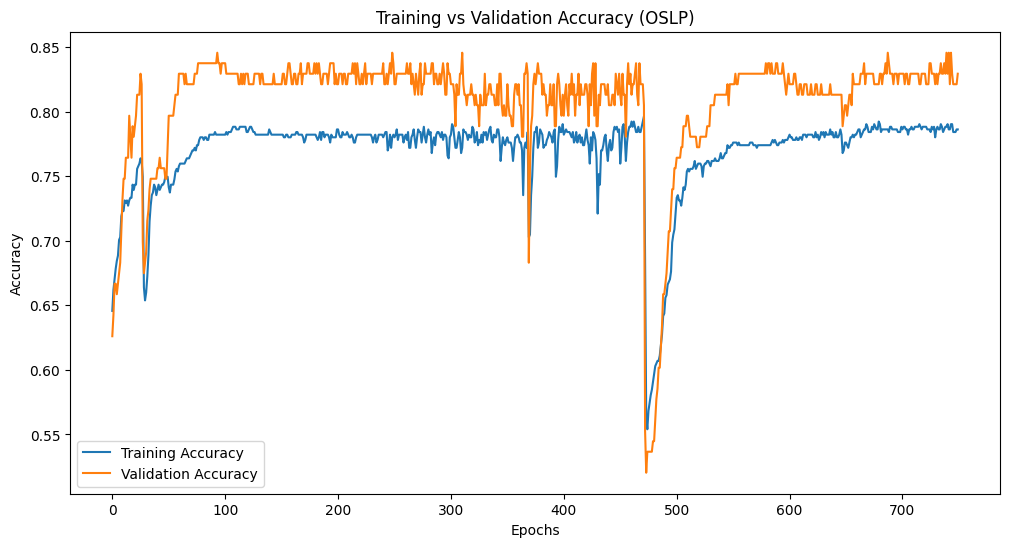

In [17]:
# Plot of Training vs Validation Accuracy over Epochs (OSLP)
plt.figure(figsize=(12, 6))
plt.plot(train_record_oslp.history['accuracy'], label='Training Accuracy')
plt.plot(train_record_oslp.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (OSLP)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

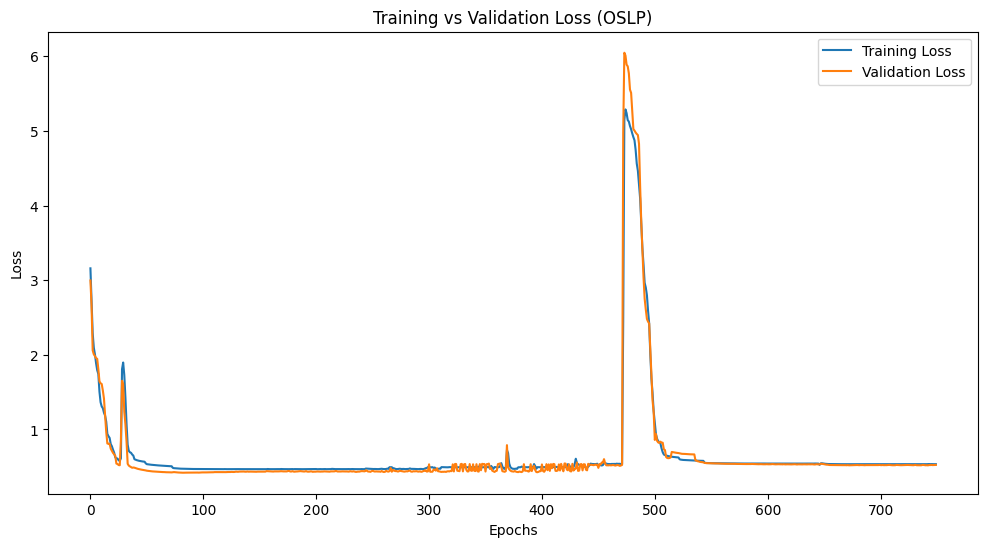

In [18]:
# Plot of Training vs Validation Loss over Epochs (OSLP)
plt.figure(figsize=(12, 6))
plt.plot(train_record_oslp.history['loss'], label='Training Loss')
plt.plot(train_record_oslp.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (OSLP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

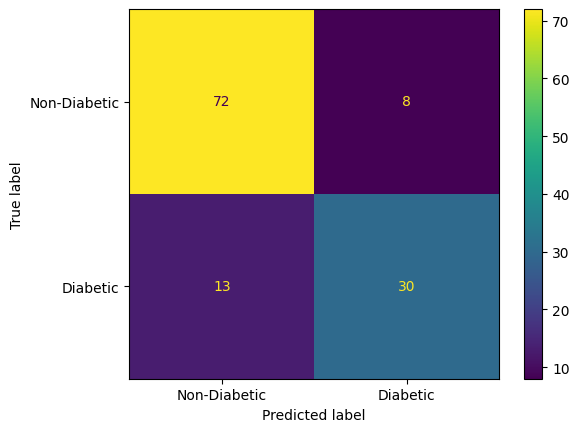

In [19]:
# True vs Predicted Labels (OSLP)
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_oslp, display_labels=['Non-Diabetic', 'Diabetic'])
plt.show()

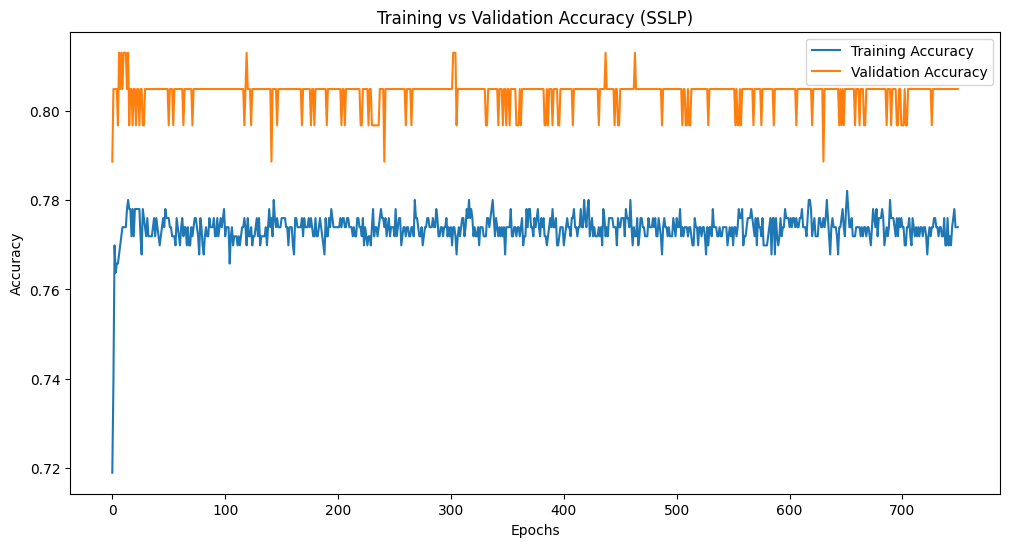

In [20]:
# Plot of Training vs Validation Accuracy over Epochs (SSLP)
plt.figure(figsize=(12, 6))
plt.plot(train_record_sslp.history['accuracy'], label='Training Accuracy')
plt.plot(train_record_sslp.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (SSLP)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

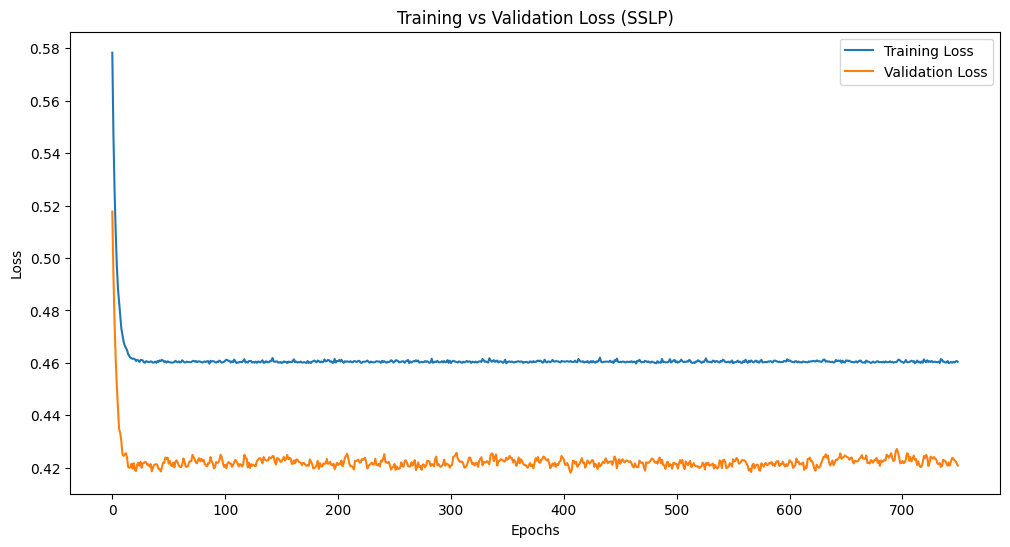

In [21]:
# Plot of Training vs Validation Loss over Epochs (SSLP)
plt.figure(figsize=(12, 6))
plt.plot(train_record_sslp.history['loss'], label='Training Loss')
plt.plot(train_record_sslp.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (SSLP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

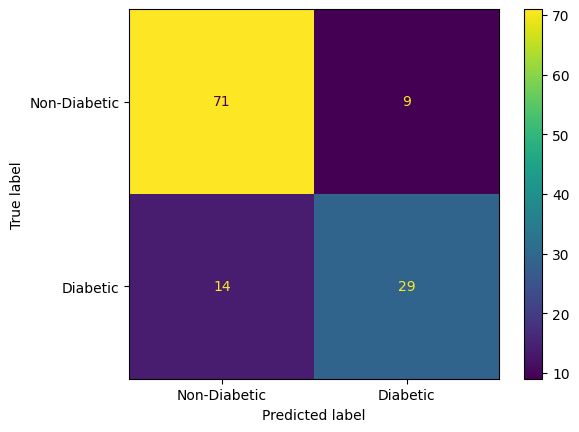

In [22]:
# True vs Predicted Labels (SSLP)
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_sslp, display_labels=['Non-Diabetic', 'Diabetic'])
plt.show()

# Secondary Model Training, Testing, & Evaluation

In [36]:
# Re-train the OSLP with the combined trainval dataset and ideal parameters

# Map best parameters to Perceptron parameters, instantiate, and train the Perceptron
final_oslp = osl_perceptron(learning_rate=best_params['learning_rate'],
                            activation=best_params['activation'],
                            regularization=best_params['regularization'],
                            lambda_=best_params['lambda_'],
                            optimizer=best_params['optimizer'])

trainval_record_oslp = final_oslp.fit(X_trainval_scaled, y_trainval, epochs=best_params['epochs'], batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2)

Epoch 1/750
20/20 - 1s - 39ms/step - accuracy: 0.4886 - loss: 6.8060 - val_accuracy: 0.4675 - val_loss: 6.3373
Epoch 2/750
20/20 - 0s - 4ms/step - accuracy: 0.5489 - loss: 5.6393 - val_accuracy: 0.5390 - val_loss: 5.1790
Epoch 3/750
20/20 - 0s - 4ms/step - accuracy: 0.6010 - loss: 4.7159 - val_accuracy: 0.5909 - val_loss: 4.1689
Epoch 4/750
20/20 - 0s - 4ms/step - accuracy: 0.6270 - loss: 3.8971 - val_accuracy: 0.6299 - val_loss: 3.6120
Epoch 5/750
20/20 - 0s - 4ms/step - accuracy: 0.6792 - loss: 3.0890 - val_accuracy: 0.6364 - val_loss: 3.4742
Epoch 6/750
20/20 - 0s - 4ms/step - accuracy: 0.7068 - loss: 2.7850 - val_accuracy: 0.6429 - val_loss: 3.5919
Epoch 7/750
20/20 - 0s - 4ms/step - accuracy: 0.7231 - loss: 2.5073 - val_accuracy: 0.6948 - val_loss: 2.9606
Epoch 8/750
20/20 - 0s - 4ms/step - accuracy: 0.7313 - loss: 2.2150 - val_accuracy: 0.6818 - val_loss: 3.1086
Epoch 9/750
20/20 - 0s - 4ms/step - accuracy: 0.7394 - loss: 2.1387 - val_accuracy: 0.6883 - val_loss: 3.1050
Epoch 10/

In [24]:
# Evaluate the OSLP model on the Testing dataset

# Use the re-trained perceptron to predict on the testing set
y_test_pred_oslp = (final_oslp.predict(X_test_scaled) > (0.0 if best_params['activation'] == 'binary' else 0.5)).astype(int).flatten()

# Calculate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_oslp)
print(f"Testing Accuracy: {Colours.GREEN}{test_accuracy:.2f}{Colours.ENDC}")

# Calculate the balanced accuracy
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred_oslp)
print(f"Testing Balanced Accuracy: {Colours.GREEN}{test_balanced_accuracy:.2f}{Colours.ENDC}")

print(f"{Colours.BOLD}Testing Classification Report:{Colours.ENDC}")
print(classification_report(y_test, y_test_pred_oslp, target_names=['Non-Diabetic', 'Diabetic']))

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:6 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D02CAC0720> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing Accuracy: 0.71
Testing Balanced Accuracy: 0.67
Testing Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.76      0.81      0.79       100
   

In [37]:
# Simple Single-Layer Perceptron (SSLP) Re-Training
final_sslp = ssl_perceptron(learning_rate=best_params['learning_rate'])

trainval_record_sslp = final_sslp.fit(X_trainval_scaled, y_trainval, epochs=best_params['epochs'], batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2)

Epoch 1/750
20/20 - 1s - 37ms/step - accuracy: 0.6629 - loss: 0.6577 - val_accuracy: 0.6688 - val_loss: 0.6473
Epoch 2/750
20/20 - 0s - 4ms/step - accuracy: 0.6971 - loss: 0.5899 - val_accuracy: 0.6623 - val_loss: 0.6100
Epoch 3/750
20/20 - 0s - 4ms/step - accuracy: 0.7248 - loss: 0.5458 - val_accuracy: 0.6688 - val_loss: 0.5780
Epoch 4/750
20/20 - 0s - 4ms/step - accuracy: 0.7476 - loss: 0.5179 - val_accuracy: 0.6818 - val_loss: 0.5568
Epoch 5/750
20/20 - 0s - 4ms/step - accuracy: 0.7606 - loss: 0.4986 - val_accuracy: 0.6948 - val_loss: 0.5424
Epoch 6/750
20/20 - 0s - 4ms/step - accuracy: 0.7736 - loss: 0.4837 - val_accuracy: 0.7208 - val_loss: 0.5343
Epoch 7/750
20/20 - 0s - 4ms/step - accuracy: 0.7752 - loss: 0.4745 - val_accuracy: 0.7143 - val_loss: 0.5266
Epoch 8/750
20/20 - 0s - 4ms/step - accuracy: 0.7769 - loss: 0.4674 - val_accuracy: 0.7143 - val_loss: 0.5212
Epoch 9/750
20/20 - 0s - 4ms/step - accuracy: 0.7785 - loss: 0.4630 - val_accuracy: 0.7208 - val_loss: 0.5198
Epoch 10/

In [26]:
# Re-Evaluate SSLP

# Use the re-trained perceptron to predict on the testing set
y_test_pred_sslp = (final_sslp.predict(X_test_scaled) > 0.0).astype(int).flatten()

# Calculate the accuracy
test_accuracy_sslp = accuracy_score(y_test, y_test_pred_sslp)
print(f"Testing Accuracy: {Colours.GREEN}{test_accuracy_sslp:.2f}{Colours.ENDC}")

# Calculate the balanced accuracy
test_balanced_accuracy_sslp = balanced_accuracy_score(y_test, y_test_pred_sslp)
print(f"Testing Balanced Accuracy: {Colours.GREEN}{test_balanced_accuracy_sslp:.2f}{Colours.ENDC}")

# Display a classification report
print(f"{Colours.BOLD}Testing Classification Report:{Colours.ENDC}")
print(classification_report(y_test, y_test_pred_sslp, target_names=['Non-Diabetic', 'Diabetic']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing Accuracy: 0.69
Testing Balanced Accuracy: 0.65
Testing Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.75      0.80      0.77       100
    Diabetic       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



In [27]:
# Dummy Classifier

# Train
dummyPipeline.fit(X_trainval, y_trainval)

# Predict
dummy_test_pred = dummyPipeline.predict(X_test)

# Evaluate
print(f"{Colours.BOLD}Dummy Testing Classification Report:{Colours.ENDC}")
print(classification_report(y_test, dummy_test_pred, target_names=['Non-Diabetic', 'Diabetic']))

Dummy Testing Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.61      0.58      0.59       100
    Diabetic       0.29      0.31      0.30        54

    accuracy                           0.49       154
   macro avg       0.45      0.45      0.45       154
weighted avg       0.50      0.49      0.49       154



# Secondary Training Result Visualizations

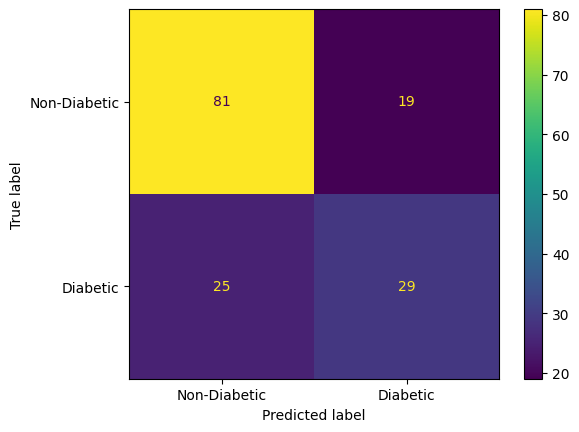

In [30]:
# True vs Predicted Labels (OSLP)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_oslp, display_labels=['Non-Diabetic', 'Diabetic'])
plt.show()

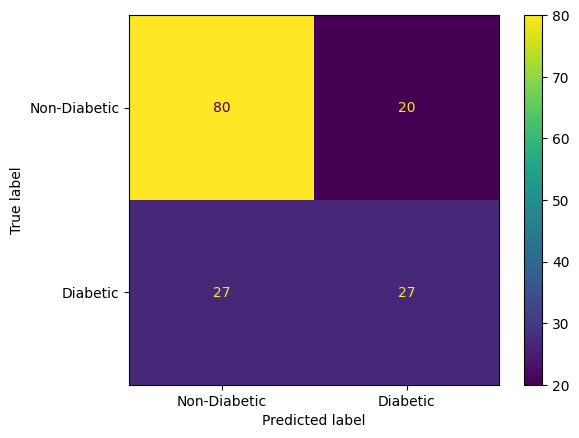

In [33]:
# True vs Predicted Labels (SSLP)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_sslp, display_labels=['Non-Diabetic', 'Diabetic'])
plt.show()